In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from config import constants

In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [197]:
IS_BINARY = False
CATEGORIES = constants.CATEGORIES
TYPE = 'binary' if IS_BINARY else 'multy'
PLOTS_DIR = './images'
MODEL_PATH = './models'
if IS_BINARY:
    TYPE = 'binary'
    DATASET_PATH = 'datasets/data/benign_or_attack_merged/benign_or_attack.csv'
    params = {
        'batch_size': 128,
        'n_d': 16,
        'n_a': 16,
        'n_steps': 5,
        'gamma': 1.5,
        'n_independent': 2,
        'n_shared': 2,
        'learning_rate': 0.001,
        'weight_decay': 1e-5
    }
else:
    TYPE = 'multy'
    DATASET_PATH = 'datasets/data/different_features/traffic_features.csv'
    params = {
        'batch_size': 64,
        'n_d': 32,
        'n_a': 32,
        'n_steps': 4,
        'gamma': 1.3,
        'n_independent': 2,
        'n_shared': 2,
        'learning_rate': 0.005,
        'weight_decay': 1e-5
    }

print(f'DATASET_PATH: {DATASET_PATH}')

DATASET_PATH: datasets/data/different_features/traffic_features.csv


In [198]:
data = pd.read_csv(DATASET_PATH, delimiter=',')
print(f"Размер: {data.shape[0]} строк, {data.shape[1]} столбцов")

Размер: 1279 строк, 78 столбцов


In [199]:
data['Label'].unique()

array(['cloud_service', 'e-mail', 'games', 'information', 'music',
       'social_network', 'video_hosting'], dtype=object)

In [200]:
class_counts = pd.Series(data['Label']).value_counts()
class_percentages = pd.Series(data['Label']).value_counts(normalize=True) * 100
distribution_df = pd.DataFrame({
    'Количество': class_counts,
    'Процент': class_percentages.round(2)
}).sort_index()

print(distribution_df)

                Количество  Процент
Label                              
cloud_service          120     9.38
e-mail                 120     9.38
games                  432    33.78
information            170    13.29
music                  142    11.10
social_network         172    13.45
video_hosting          123     9.62


In [201]:
X = data.drop('Label', axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Label'])
class_names = label_encoder.classes_

for i in range(0, len(class_names)):
    print(f"{np.unique(y)[i]}: {class_names[i]}")

0: cloud_service
1: e-mail
2: games
3: information
4: music
5: social_network
6: video_hosting


In [202]:
feature_names = X.columns
print(feature_names)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [203]:
if not IS_BINARY:
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)

print(X.shape, y.shape)

(3024, 77) (3024,)


In [204]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [205]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
print(f"Classes: {np.unique(y)} \nWeights: {class_weights}")
class_weights = torch.FloatTensor(class_weights).to(device)

Classes: [0 1 2 3 4 5 6] 
Weights: [1. 1. 1. 1. 1. 1. 1.]


In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [207]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [208]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size'), shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=params.get('batch_size'), shuffle=False)

In [209]:
class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_d=32, n_a=32, n_steps=3, gamma=1.3,
                 n_independent=2, n_shared=2, momentum=0.02):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.momentum = momentum

        self.initial_bn = nn.BatchNorm1d(input_dim, momentum=momentum)
        self.initial_splitter = FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
        self.attentive_transformers = nn.ModuleList([
            AttentiveTransformer(input_dim, n_a, momentum) for _ in range(n_steps)
        ])
        self.feature_transformers = nn.ModuleList([
            FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
            for _ in range(n_steps)
        ])
        self.final_linear = nn.Linear(n_d, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.initial_bn(x)
        prior = torch.ones(batch_size, self.input_dim, device=x.device)
        M_loss = 0
        outputs = []
        M = []

        features = self.initial_splitter(x)
        d, a = features[:, :self.n_d], features[:, self.n_d:]

        for step in range(self.n_steps):
            M_i = self.attentive_transformers[step](a, prior)
            M.append(M_i)
            M_loss += torch.mean(torch.sum(-M_i * torch.log(M_i + 1e-15), dim=1))
            prior = self.gamma - M_i
            prior = torch.cumprod(prior, dim=0)
            masked_x = M_i * x
            features = self.feature_transformers[step](masked_x)
            d, a = features[:, :self.n_d], features[:, self.n_d:]
            outputs.append(d)

        out = torch.stack(outputs, dim=1).sum(dim=1)
        out = self.final_linear(out)
        return out, M, M_loss / self.n_steps

In [210]:
class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_independent, n_shared, momentum):
        super(FeatureTransformer, self).__init__()
        self.shared = nn.ModuleList()
        for i in range(n_shared):
            in_features = input_dim if i == 0 else output_dim
            self.shared.append(nn.Sequential(
                nn.Linear(in_features, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU(),
                nn.Dropout(0.1)
            ))
        self.independent = nn.ModuleList()
        for _ in range(n_independent):
            self.independent.append(nn.Sequential(
                nn.Linear(output_dim, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU(),
                nn.Dropout(0.1)
            ))

    def forward(self, x):
        shared_out = x
        for layer in self.shared:
            shared_out = layer(shared_out)
        out = shared_out
        for layer in self.independent:
            out = layer(out)
        return out

In [211]:
class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, n_a, momentum):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(n_a, input_dim)
        self.bn = nn.BatchNorm1d(input_dim, momentum=momentum)

    def forward(self, a, prior):
        a = self.fc(a)
        a = self.bn(a)
        a = a * prior
        return sparsemax(a)

In [212]:
def sparsemax(x):
    sorted_x, _ = torch.sort(x, dim=1, descending=True)
    cumsum = torch.cumsum(F.softmax(sorted_x, dim=1), dim=1)
    rho = (cumsum <= 1).sum(dim=1, keepdim=True)
    tau = (cumsum.gather(1, rho - 1) - 1) / rho
    out = F.relu(x - tau)
    return out / (out.sum(dim=1, keepdim=True) + 1e-15)

In [213]:
def evaluate_tabnet(model, test_loader, criterion, device, is_binary=True):
    model.eval()
    total_test_loss = 0
    total_test_correct = 0
    total_test_samples = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, M_loss = model(data)
            test_loss = criterion(output, target) + 0.01 * M_loss
            total_test_loss += test_loss.item()
            pred = output.argmax(dim=1)
            total_test_correct += pred.eq(target).sum().item()
            total_test_samples += target.size(0)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(target.cpu().numpy())

    test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * total_test_correct / total_test_samples
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary' if is_binary else 'weighted', zero_division=0
    )

    return test_loss, test_accuracy, precision, recall, f1, y_true, y_pred

In [214]:
def train_tabnet(model, train_loader, test_loader, optimizer, epochs, device, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

    train_losses = []
    test_losses = []
    test_accuracies = []

    best_val_loss = float('inf')
    patience = 5
    counter = 0
    best_model_path = './models/best_model.pth'

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output, M, M_loss = model(data)
            loss = criterion(output, target) + 0.01 * M_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pred = output.argmax(dim=1)
            total_train_correct += pred.eq(target).sum().item()
            total_train_samples += target.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * total_train_correct / total_train_samples
        train_losses.append(train_loss)

        test_loss, test_accuracy, precision, recall, f1, y_true, y_pred = evaluate_tabnet(
            model, test_loader, criterion, device, is_binary=IS_BINARY
        )
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        scheduler.step(test_loss)

        print(f'\nЭпоха {epoch+1}/{epochs}:')
        print(f'  Тренировочные потери: {train_loss:.4f}, Тренировочная точность: {train_accuracy:.2f}%')
        print(f'  Тестовые потери: {test_loss:.4f}, Тестовая точность: {test_accuracy:.2f}%')
        print(f'  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n')

        # Механизм ранней остановки
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Найдена лучшая модель с потерями: {best_val_loss:.4f}")
        else:
            counter += 1
            print(f"Потери не улучшились ({counter}/{patience})")
            if counter >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}")
                model.load_state_dict(torch.load(best_model_path))
                break

    return train_losses, test_losses, test_accuracies

In [215]:
input_dim = X.shape[1]
output_dim = len(np.unique(y))

model = TabNet(input_dim=input_dim,
               output_dim=output_dim,
               n_d=params.get("n_d"),
               n_a=params.get("n_a"),
               n_steps=params.get("n_steps"),
               gamma=params.get("gamma"),
               n_independent=params.get("n_independent"),
               n_shared=params.get("n_shared"),
               momentum=params.get("momentum")
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params.get("learning_rate"), weight_decay=params.get("weight_decay"))

In [216]:
epochs = 100
train_losses, test_losses, test_accuracies = train_tabnet(model,
                                                          train_loader,
                                                          test_loader,
                                                          optimizer,
                                                          epochs,
                                                          device,
                                                          class_weights)


Эпоха 1/100:
  Тренировочные потери: 1.5488, Тренировочная точность: 43.01%
  Тестовые потери: 1.8773, Тестовая точность: 37.89%
  Precision: 0.5068, Recall: 0.3789, F1: 0.3175

Найдена лучшая модель с потерями: 1.8773

Эпоха 2/100:
  Тренировочные потери: 1.1764, Тренировочная точность: 58.79%
  Тестовые потери: 1.2963, Тестовая точность: 50.88%
  Precision: 0.6090, Recall: 0.5088, F1: 0.4761

Найдена лучшая модель с потерями: 1.2963

Эпоха 3/100:
  Тренировочные потери: 1.0010, Тренировочная точность: 65.04%
  Тестовые потери: 1.2333, Тестовая точность: 58.59%
  Precision: 0.6750, Recall: 0.5859, F1: 0.5864

Найдена лучшая модель с потерями: 1.2333

Эпоха 4/100:
  Тренировочные потери: 0.8993, Тренировочная точность: 69.30%
  Тестовые потери: 0.9737, Тестовая точность: 67.62%
  Precision: 0.7026, Recall: 0.6762, F1: 0.6768

Найдена лучшая модель с потерями: 0.9737

Эпоха 5/100:
  Тренировочные потери: 0.8337, Тренировочная точность: 70.82%
  Тестовые потери: 1.1562, Тестовая точност

In [228]:
all_dataset = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)
model.eval()
y_pred_all = []
y_true_all = []

with torch.no_grad():
    for data, target in all_loader:
        data, target = data.to(device), target.to(device)
        output, _, _ = model(data)
        pred = output.argmax(dim=1)
        y_pred_all.extend(pred.cpu().numpy())
        y_true_all.extend(target.cpu().numpy())

# Вычисление метрик на всём датасете
overall_accuracy = 100. * np.mean(np.array(y_pred_all) == y_true_all)
precision, recall, f1, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average='weighted', zero_division=0)

# Вывод результатов
print(f"\nМетрики на всём датасете:")
print(f"Общая точность (Accuracy): {overall_accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Детализация по классам (опционально)
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average=None, zero_division=0)
for i, class_name in enumerate(class_names):
    print(f"Класс {class_name} (индекс {i}): Precision = {precision_per_class[i]:.2f}, Recall = {recall_per_class[i]:.2f}, F1 = {f1_per_class[i]:.2f}")

# Визуализация метрик
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value (%)': [overall_accuracy, precision * 100, recall * 100, f1 * 100]
}
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value (%)', data=metrics_df, palette='viridis')
plt.title('Общие метрики на всём датасете')
plt.ylabel('Значение (%)')
plt.ylim(0, 100)
for i, v in enumerate(metrics_df['Value (%)']):
    plt.text(i, v + 1, f'{v:.2f}', ha='center')
plt.savefig(os.path.join(PLOTS_DIR, 'overall_metrics.png'))
plt.close()

# Матрица ошибок для всего датасета
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок на всём датасете')
plt.savefig(os.path.join(PLOTS_DIR, 'confusion_matrix_all.png'))
plt.close()


Метрики на всём датасете:
Общая точность (Accuracy): 93.02%
Precision: 0.93
Recall: 0.93
F1-Score: 0.93
Класс cloud_service (индекс 0): Precision = 0.93, Recall = 0.91, F1 = 0.92
Класс e-mail (индекс 1): Precision = 0.96, Recall = 0.94, F1 = 0.95
Класс games (индекс 2): Precision = 0.90, Recall = 0.95, F1 = 0.92
Класс information (индекс 3): Precision = 0.96, Recall = 0.89, F1 = 0.92
Класс music (индекс 4): Precision = 0.89, Recall = 0.95, F1 = 0.92
Класс social_network (индекс 5): Precision = 0.96, Recall = 0.97, F1 = 0.97
Класс video_hosting (индекс 6): Precision = 0.91, Recall = 0.92, F1 = 0.91


C:\Users\owtf0\AppData\Local\Temp\ipykernel_11804\1313384646.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value (%)', data=metrics_df, palette='viridis')


In [219]:
def get_feature_importance(model, data_loader, device, feature_names):
    model.eval()
    feature_importance = torch.zeros(model.input_dim).to(device)
    total_samples = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            _, masks, _ = model(data)
            for mask in masks:
                feature_importance += mask.sum(dim=0)
            total_samples += data.size(0)
    importance = feature_importance.cpu().numpy() / total_samples

    return pd.Series(importance, index=feature_names)

In [220]:
def evaluate_model(model, test_loader, device, is_binary):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, M_loss = model(data)
            loss = criterion(output, target) + 0.01 * M_loss
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(target.cpu().numpy())
            if is_binary:
                scores = torch.softmax(output, dim=1)[:, 1]
                y_scores.extend(scores.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                               average='binary' if is_binary else 'weighted')
    cm = confusion_matrix(y_true, y_pred)

    # ROC-кривая (только для бинарной классификации)
    roc_data = None
    if is_binary and y_scores:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        roc_data = (fpr, tpr, roc_auc)

    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_data': roc_data
    }

In [221]:
def plot_results(train_losses, test_losses, test_accuracies, eval_results, class_names, is_binary):
    # График потерь
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Тренировочные потери')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Тестовые потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Тренировочные и тестовые потери по эпохам')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(PLOTS_DIR, 'loss_plot.png'))
    plt.close()

    # График точности
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Тестовая точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.title('Тестовая точность по эпохам')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(PLOTS_DIR, 'accuracy_plot.png'))
    plt.close()

    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(eval_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.savefig(os.path.join(PLOTS_DIR, 'confusion_matrix.png'))
    plt.close()

    # ROC-кривая (только для бинарной классификации)
    if is_binary and eval_results['roc_data']:
        fpr, tpr, roc_auc = eval_results['roc_data']
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая')
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(PLOTS_DIR, 'roc_curve.png'))
        plt.close()

In [222]:
eval_results = evaluate_model(model, test_loader, device, IS_BINARY)

print(eval_results)

# Визуализация
plot_results(train_losses, test_losses, test_accuracies, eval_results, class_names, IS_BINARY)

{'test_loss': 0.3537925146520138, 'accuracy': 90.52863436123349, 'precision': 0.906304343120313, 'recall': 0.9052863436123348, 'f1': 0.9055590263487535, 'confusion_matrix': array([[58,  2,  1,  0,  0,  1,  2],
       [ 1, 60,  1,  1,  1,  0,  1],
       [ 2,  0, 59,  0,  1,  1,  2],
       [ 1,  0,  3, 57,  2,  0,  2],
       [ 1,  1,  0,  0, 58,  0,  5],
       [ 0,  0,  0,  2,  1, 62,  0],
       [ 1,  0,  0,  2,  3,  2, 57]]), 'roc_data': None}



Важность признаков (топ-10):
Bwd Avg Packets/Bulk       0.098575
FIN Flag Count             0.088553
Bwd IAT Max                0.086121
Init_Win_bytes_backward    0.085093
Fwd Avg Packets/Bulk       0.083573
Fwd IAT Max                0.080489
Fwd Packet Length Std      0.079627
Destination Port           0.074669
Flow Duration              0.072533
Fwd Packet Length Min      0.070964
dtype: float32


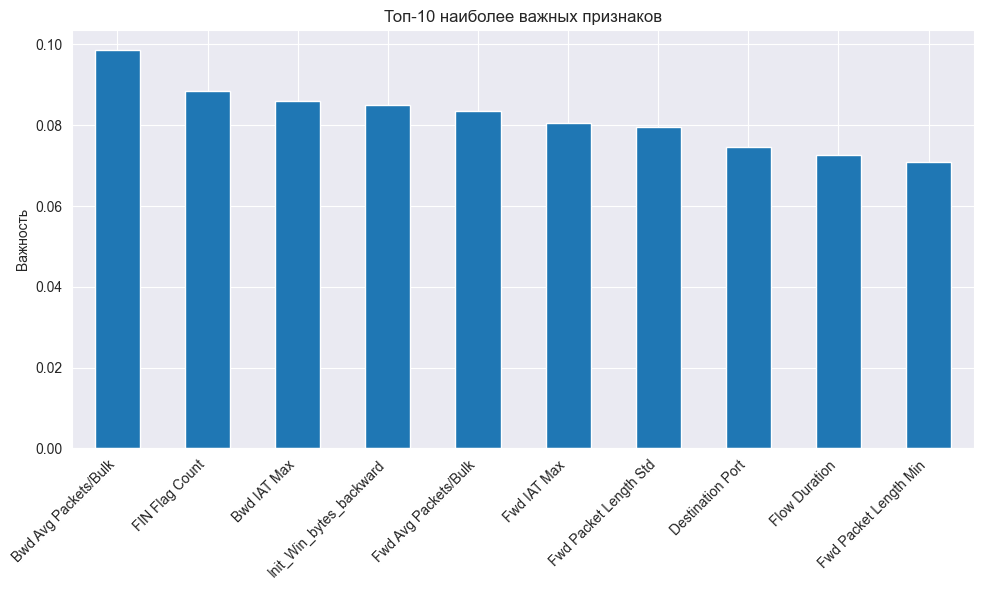

In [223]:
# Анализ важности признаков
importance = get_feature_importance(model, test_loader, device, feature_names)
print("\nВажность признаков (топ-10):")
print(importance.sort_values(ascending=False).head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
importance.sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Топ-10 наиболее важных признаков')
plt.ylabel('Важность')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [227]:
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model_filename = f"tabnet_{TYPE}_{epochs}.pth"
full_path = os.path.join(MODEL_PATH, model_filename)
torch.save(model, full_path)
print(f"Модель сохранена полностью в {full_path}")

Модель сохранена полностью в ./models\tabnet_multy_100.pth
